In [1]:
import re
import nltk
import collections
import math
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
import random
import pickle
from nltk.corpus import reuters

In [2]:
#load the required data
def load_data(master_dict):
    with open(master_dict, "rb") as f:
        data = pickle.load(f)
    return data 

data = load_data("dict.dat")

In [3]:
#get all the trained variables
embeddings = data['embeddings']
reverse_dictionary = data['reverse_dictionary']
dictionary = data['dictionary']

#delete data to free some memory
del(data)

In [4]:
documents = reuters.fileids()
train_docs = list(filter(lambda doc: doc.startswith("test"),documents));
all_sents = []
for doc in train_docs:
    sent = reuters.sents(fileids=[doc])
    all_sents = all_sents + list(sent)

In [5]:
#read the input file and store it in a string
def read_file(filename):
    with open(filename, 'r') as myfile:
        text = myfile.read().decode("utf-8").replace('\n', '')
    return text
# add file name in the argument
text = read_file('gst.txt')
print(text)

Goods and Services Tax (GST) is an indirect tax applicable throughout India which replaced multiple cascading taxes levied by the central and state governments. It was introduced as The Constitution (One Hundred and First Amendment) Act 2017, following the passage of Constitution 122nd Amendment Bill. The GST is governed by a GST Council and its Chairman is the Finance Minister of India. Under GST, goods and services are taxed at the following rates, 0%, 5%, 12% and 18%. There is a special rate of 0.25% on rough precious and semi-precious stones and 3% on gold. In addition a cess of 15% or other rates on top of 28% GST applies on few items like aerated drinks, luxury cars and tobacco products.Touted by the government to be India's biggest tax reform in 70 years of independence, the Goods and Services Tax (GST) was finally launched on the midnight of 30 June 2017, though the process of forming the legislation took 17 years (since 2000 when it was first proposed). The launch was marked b

In [6]:
# get the sentences
sents = nltk.sent_tokenize(text)
print(len(sents))

49


In [7]:
# # for each sentence word tokenize it
words = [nltk.word_tokenize(sent) for sent in sents]
print(words)

[[u'Goods', u'and', u'Services', u'Tax', u'(', u'GST', u')', u'is', u'an', u'indirect', u'tax', u'applicable', u'throughout', u'India', u'which', u'replaced', u'multiple', u'cascading', u'taxes', u'levied', u'by', u'the', u'central', u'and', u'state', u'governments', u'.'], [u'It', u'was', u'introduced', u'as', u'The', u'Constitution', u'(', u'One', u'Hundred', u'and', u'First', u'Amendment', u')', u'Act', u'2017', u',', u'following', u'the', u'passage', u'of', u'Constitution', u'122nd', u'Amendment', u'Bill', u'.'], [u'The', u'GST', u'is', u'governed', u'by', u'a', u'GST', u'Council', u'and', u'its', u'Chairman', u'is', u'the', u'Finance', u'Minister', u'of', u'India', u'.'], [u'Under', u'GST', u',', u'goods', u'and', u'services', u'are', u'taxed', u'at', u'the', u'following', u'rates', u',', u'0', u'%', u',', u'5', u'%', u',', u'12', u'%', u'and', u'18', u'%', u'.'], [u'There', u'is', u'a', u'special', u'rate', u'of', u'0.25', u'%', u'on', u'rough', u'precious', u'and', u'semi-precio

In [8]:
#lowercasing the text
#remove the words if present in stop list
#removing non alphanumeric and numeric text
#getting the indices of the words
StopWords = stopwords.words("english")
stemmer = PorterStemmer()
index_processed = []
text_processed = []
p = re.compile('[a-zA-Z]+');
for sent in words:
    sent = map(lambda word: word.lower(), sent);
    sent = [word for word in sent if word not in StopWords]
    doc = [stemmer.stem(word) for word in doc]
    filtered_tokens =list(filter(lambda token:p.match(token),sent));
    text_processed.append(filtered_tokens)
    index = [dictionary[word] if word in dictionary else 0 for word in filtered_tokens]
    index_processed.append(index)


In [9]:
#get sent vectors
sent_vec=[]
for _ in index_processed:
    sent_vec.append(np.sum(embeddings[_],axis=0)/len(_))
sent_vec = np.array(sent_vec)

In [10]:
sent_vec.shape

(49, 256)

In [11]:
#cluster the vectors using k means algo
#choose your own n_clusters 1
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 12, random_state=0).fit(sent_vec)

In [12]:
cluster = collections.Counter(kmeans.labels_).most_common(6)
print((cluster))

[(1, 11), (12, 8), (2, 7), (4, 6), (9, 5), (3, 3)]


In [13]:
#get the centroid vector and find the nearest vector to it in cluster
from scipy import spatial
def central_vec(kmeans,cluster):
    c_vec = []
    vec_index = []
    for label,_ in cluster:
        index = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == label ]
        tree = spatial.KDTree(sent_vec[index])
        #print(tree)
        query = np.sum(sent_vec,0)/_
        d,ind = tree.query(query)
        central_vec = sent_vec[index][ind]
        c_vec.append(central_vec)
        vec_index.append(index[ind])
    return c_vec,vec_index
c ,v= np.array(central_vec(kmeans,cluster))
#c.shape
print(v)

[33 15 34 1 3 20]


In [14]:
#given the req index print the sentences coressponding to it
def print_summary(index):
    for i in index:
        print(sents[i])
        
print_summary(v)

For inter-state transactions and imported goods or services, an Integrated GST (IGST) is levied by the Central Government.
However in 2010, with the Trinamool Congress routing CPI(M) out of power in West Bengal, Asim Dasgupta resigned as the head of the GST committee.
GST is a consumption-based tax, therefore, taxes are paid to the state where the goods or services are consumed not the state in which they were produced.
It was introduced as The Constitution (One Hundred and First Amendment) Act 2017, following the passage of Constitution 122nd Amendment Bill.
Under GST, goods and services are taxed at the following rates, 0%, 5%, 12% and 18%.
In May 2015, the Lok Sabha passed the Constitution Amendment Bill, paving way for GST.


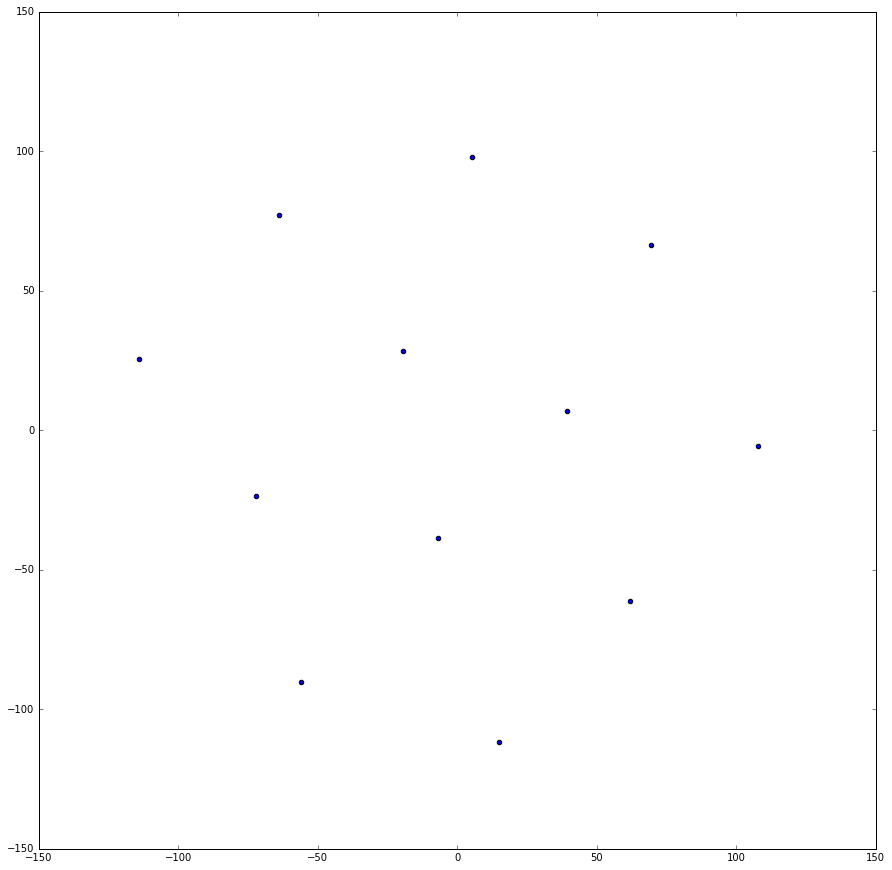

In [15]:
from sklearn.manifold import TSNE
num_points = 12

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(sent_vec[1:num_points+1, :])
two_d_embeddings.shape
from matplotlib import pylab
def plot(embeddings):
  #assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i in range(num_points):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    #pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   #ha='right', va='bottom')
  pylab.show()

#words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings)